## Importation Librairies

.Installation

In [15]:
#pip install sqldf

In [16]:
#pip install xlrd

In [17]:
import pandas as pd
import numpy as np
import random
import datetime
import sqldf
from decimal import *
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics
#from sklearn.metrics confusion_matrix
#from sklearn.metrics accuracy_score
#from sklearn.metrics classification_report
from sklearn.cluster import KMeans
import io
import requests



## # Create a dummy pd.Dataframe

In [18]:
df = pd.read_excel('data/ONLINE_RETAILS.xlsx')

In [19]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Preprocessing

In [20]:
data = df.copy()

In [21]:
data.shape

(541909, 8)

In [22]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [23]:
data.isnull

<bound method DataFrame.isnull of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  Cu

In [24]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"].dt.strftime('%Y-%m-%d')) # 1* 
snapshot = data["InvoiceDate"].max() # 2* 
snapshot = snapshot + pd.Timedelta(days=1) # 3* 
print("Our snapshot date: ",snapshot)
data.head()

Our snapshot date:  2011-12-10 00:00:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [25]:
data['total_price'] = data["Quantity"] * data["UnitPrice"]
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [26]:
customer_group = data.groupby("CustomerID") 
recency = (snapshot - customer_group["InvoiceDate"].max()) 
frequency = customer_group["InvoiceNo"].nunique() 
monetary = customer_group["total_price"].sum()
tenure = snapshot - customer_group["InvoiceDate"].min()  
rfm = rfm = pd.DataFrame() 
rfm["Recency"] = recency.dt.days 
rfm["Frequency"] = frequency
rfm["Monetary"] = monetary
rfm["Tenure"] = tenure.dt.days 
rfm.head().reset_index()

,CustomerID,Recency,Frequency,Monetary,Tenure
0,12346.0,326,2,0.00,326
1,12347.0,3,7,4310.00,368
2,12348.0,76,4,1797.24,359
3,12349.0,19,1,1757.55,19
4,12350.0,311,1,334.40,311


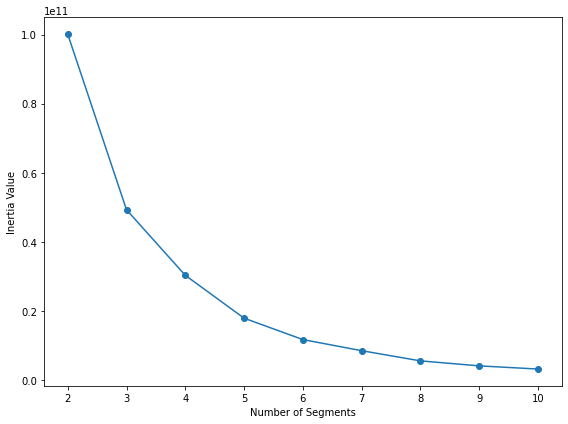

In [27]:
X = rfm.values 
n_cluster = range(2, 11, 1) 
inertia_value = []


for i in n_cluster:
    model = KMeans(n_clusters=i, random_state=13)
    model.fit(X)
    inertia_value.append(model.inertia_)
    
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1)
ax.plot(n_cluster, inertia_value, marker="o")

ax.set_xlabel("Number of Segments")
ax.set_ylabel("Inertia Value")

fig.tight_layout()

In [28]:
n_cluster = 5

model = KMeans(n_clusters=n_cluster, random_state=28)
y = model.fit_predict(X)

rfm["Segment"] = y
rfm.head().reset_index() 

,CustomerID,Recency,Frequency,Monetary,Tenure,Segment
0,12346.0,326,2,0.00,326,0
1,12347.0,3,7,4310.00,368,0
2,12348.0,76,4,1797.24,359,0
3,12349.0,19,1,1757.55,19,0
4,12350.0,311,1,334.40,311,0


In [29]:
humanization = {3:"Diamond", 1:"Platinum", 2:"Gold" , 4:"Silver", 0:"Bronze"}
rfm["Segment"].replace(humanization,inplace=True)
rfm.reset_index()

,CustomerID,Recency,Frequency,Monetary,Tenure,Segment
0,12346.0,326,2,0.00,326,Bronze
1,12347.0,3,7,4310.00,368,Bronze
2,12348.0,76,4,1797.24,359,Bronze
3,12349.0,19,1,1757.55,19,Bronze
4,12350.0,311,1,334.40,311,Bronze
...,...,...,...,...,...,...
4367,18280.0,278,1,180.60,278,Bronze
4368,18281.0,181,1,80.82,181,Bronze
4369,18282.0,8,3,176.60,127,Bronze
4370,18283.0,4,16,2094.88,338,Bronze


Suppression de la colonne Total prix

In [30]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [31]:
del data['total_price']

In [32]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


## Nettoyage de données
- On constate la présence des valeurs négatives 
- Nous allons donc nous focaliser que sur les valeurs positives

In [33]:
data_c= data.copy()
data_c

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France


In [34]:
Neg_value = data[data['Quantity']<0].head()

In [35]:
Neg_value

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01,0.29,17548.0,United Kingdom


In [36]:
data['Quantity'] = data['Quantity'].abs()

In [37]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


Suppression des données dupliquées

In [38]:
data.drop_duplicates()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France


In [39]:
data_f = data.copy()

In [40]:
data_f.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


## Création d'une colonne dépense =  Prix * Quantité ==> quantité par dépenses
- Calculer la sum des quantités groupées par pays 
- calculer la moyenne pour avoir le nombre moyen par pays 

In [41]:
data_f['Spent'] = data_f.Quantity * data_f.UnitPrice
data_f.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


## MODIFICATION DU FORMAT DATE
On va utiliser InvoiceDate 
 - 1* On exclus l'heure et les minutes pour faciliter notre analyse
 - 2* La dernière date devient notre date max
 - 3* On ajoute 1 jour à la date max 

In [42]:
#data_f["InvoiceDate"] = pd.to_datetime(data_f["InvoiceDate"].dt.strftime('%Y-%m-%d')) # 1* 
#snapshot = data_f["InvoiceDate"].max() # 2* 
#snapshot = snapshot + pd.Timedelta(days=1) # 3* 
#print("Our snapshot date: ",snapshot)
#data_f.head()

Récupération de la variable Année, Mois et Jour sous forme de Colonne

In [43]:
data_f['Year'] = data_f['InvoiceDate'].dt.year
data_f['Month'] = data_f['InvoiceDate'].dt.month
data_f['Day'] = data_f['InvoiceDate'].dt.day

In [44]:
data_f.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Question 1 : VOLUME

In [45]:
data_f.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1


Process : 

Données utilisées 
- Country ==> Pays où l’achat a été réalisé
- Quantity ===> Quantité de produits 
- CustomerID ==> Identifiant de l’acheteur

In [46]:
# Volume ici correspond au nombre de produits qu'un client achète
Volume= data_f.groupby(['CustomerID']).agg({'Quantity':'sum'}).reset_index()
Volume.head()

,CustomerID,Quantity
0,12346.0,148430
1,12347.0,2458
2,12348.0,2341
3,12349.0,631
4,12350.0,197


In [47]:
# En général un client achète :
Nb_quantite = Volume.Quantity.mean().__round__(2)
Nb_quantite
print("En général un client achète " + str(Volume.Quantity.mean().__round__(2)) + " Produits")

En général un client achète 1248.06 Produits


Distribution associée

In [48]:
plt.figure(figsize=(15,8))
sns.histplot(data_f=Volume, x="StockCode", kde=True, bins=250)

ValueError: Could not interpret value `StockCode` for parameter `x`

<Figure size 1080x576 with 0 Axes>

Le volume moyen et median par pays

In [49]:
Moyenne= data_f.groupby(['Country']).agg({'Quantity':'mean'}).reset_index()

In [50]:
Moyenne = Moyenne.rename(columns={'Quantity' :'Quantity Number by Country'})

In [51]:
Moyenne.head()

,Country,Quantity Number by Country
0,Australia,67.327244
1,Austria,12.306733
2,Bahrain,19.368421
3,Belgium,11.272112
4,Brazil,11.125000


In [52]:
Mediane= data_f.groupby(['Country']).agg({'Quantity':'median'}).reset_index()

In [53]:
Mediane = Mediane.rename(columns={'Quantity' :'Quantity Numb/Country'})

In [54]:
Mediane.head()

,Country,Quantity Numb/Country
0,Australia,24
1,Austria,10
2,Bahrain,6
3,Belgium,10
4,Brazil,10


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Question  2: MONTANT

Process : 

Données utilisées 
- Quantity : Quantité de produits achetés
- UnitPrice : Prix unitaire du produit
- CustomerID ==> Identifiant de l’acheteur

In [55]:
data_f.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1


Montant correspond au montant dépensé par un client généralement

In [56]:
Montant = data_f.groupby(['CustomerID']).agg({'StockCode':'count'}).reset_index()

In [57]:
Montant

,CustomerID,StockCode
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


In [58]:
Montant = Montant.mean()

In [59]:
Montant.StockCode.round(2)
print("En général un client dépense un montant de " + str(Montant.StockCode.__round__(2)))

En général un client dépense un montant de 93.05


 Affichage la distribution associée

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(data=Montant, x="StockCode", kde=True, bins=250)

ValueError: If using all scalar values, you must pass an index

<Figure size 1080x576 with 0 Axes>

In [60]:
Montant_1 = data_f.groupby(['StockCode']).nunique()['CustomerID']

In [61]:
Montant_1.head().reset_index()

,StockCode,CustomerID
0,10002,40
1,10080,19
2,10120,25
3,10125,49
4,10133,101


In [ ]:
data_f[data_f['StockCode']==10002]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day
31,536370,10002,INFLATABLE POLITICAL GLOBE,48,2010-12-01,0.85,12583.0,France,40.80,2010,12,1
142,536382,10002,INFLATABLE POLITICAL GLOBE,12,2010-12-01,0.85,16098.0,United Kingdom,10.20,2010,12,1
4272,536756,10002,INFLATABLE POLITICAL GLOBE,1,2010-12-02,0.85,NaN,United Kingdom,0.85,2010,12,2
5466,536863,10002,INFLATABLE POLITICAL GLOBE,1,2010-12-03,0.85,17967.0,United Kingdom,0.85,2010,12,3
5546,536865,10002,INFLATABLE POLITICAL GLOBE,5,2010-12-03,1.66,NaN,United Kingdom,8.30,2010,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...
143465,548702,10002,INFLATABLE POLITICAL GLOBE,4,2011-04-03,0.85,17085.0,United Kingdom,3.40,2011,4,3
143930,548714,10002,INFLATABLE POLITICAL GLOBE,2,2011-04-03,0.85,17337.0,United Kingdom,1.70,2011,4,3
158070,550272,10002,INFLATABLE POLITICAL GLOBE,62,2011-04-15,0.85,18079.0,United Kingdom,52.70,2011,4,15
160128,550452,10002,INFLATABLE POLITICAL GLOBE,1,2011-04-18,0.85,14525.0,United Kingdom,0.85,2011,4,18


Le Montant moyen et median par pays
- Travail à faire :
    - Calculer le montant moyen et le montant médian d’un panier client, par pays

In [62]:
Montant_Moyen = data_f.groupby(['Country']).agg({'Spent':'mean'}).rename(columns={'Spent' :'Montant_Moyen'}).reset_index()
Montant_Moyen.head().round(2)

,Country,Montant_Moyen
0,Australia,111.17
1,Austria,25.54
2,Bahrain,50.52
3,Belgium,20.05
4,Brazil,35.74


In [63]:
Montant_Median = data_f.groupby(['Country']).agg({'Spent':'median'}).rename(columns={'Spent' :'Montant_Médian'}).reset_index()
Montant_Median.head().round(2)

,Country,Montant_Médian
0,Australia,52.02
1,Austria,17.34
2,Bahrain,25.50
3,Belgium,16.60
4,Brazil,19.65


In [64]:
Montant_Moyen['Montant_Médian'] = Montant_Median.Montant_Médian
Montant_Moyen.head()

,Country,Montant_Moyen,Montant_Médian
0,Australia,111.171843,52.02
1,Austria,25.543741,17.34
2,Bahrain,50.520000,25.50
3,Belgium,20.049164,16.60
4,Brazil,35.737500,19.65


-------------------------------------------------------------------------------------------------------------------------------------------------

## Question 3 : Volume: Top-5 produits


## Premier trimestre 2011
- StockCode : identifiant de produit
- Quantity : quantité de produits achetés
- InvoiceDate : date de l’achat

In [65]:
data_f.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1


In [66]:
data_top5 = data_f[ (data_f['Year']==2011) & (data_f['Month'].between(1,3))]

les top-5 produits les plus vendus 
-     Durant le premier trimestre 2011

In [67]:
Top_5_Product_1 = data_top5.groupby(['StockCode','Month']).agg({'Quantity':'sum'}).reset_index()

In [68]:
Top_5_Product_1.sort_values(['Quantity'], ascending=False).head(5)

,StockCode,Month,Quantity
4778,23166,1,148430
4885,37413,1,5568
7026,85123A,1,5544
6188,72140F,3,5368
7002,85099B,3,5283


les top-5 produits les plus vendus 
-     Pendant le second trimestre 2011

In [69]:
Mask1 = (data_f['Year']==2011)
Mask1 = data_f[Mask1]

In [70]:
Mask1.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04,1.95,13313.0,United Kingdom,19.5,2011,1,4
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,10.5,2011,1,4
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,10.5,2011,1,4
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04,2.10,13313.0,United Kingdom,10.5,2011,1,4
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04,1.25,13313.0,United Kingdom,12.5,2011,1,4


In [71]:
Mask2 = (Mask1['Month'].between(4,6))

In [72]:
data_top5_2 = Mask1[Mask2]
data_top5_2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day
142083,548550,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-04-01,1.65,18161.0,United Kingdom,16.50,2011,4,1
142084,548550,22296,HEART IVORY TRELLIS LARGE,12,2011-04-01,1.65,18161.0,United Kingdom,19.80,2011,4,1
142085,548550,21790,VINTAGE SNAP CARDS,12,2011-04-01,0.85,18161.0,United Kingdom,10.20,2011,4,1
142086,548550,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-04-01,9.95,18161.0,United Kingdom,19.90,2011,4,1
142087,548550,22393,PAPERWEIGHT VINTAGE COLLAGE,6,2011-04-01,2.55,18161.0,United Kingdom,15.30,2011,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
245898,558637,22032,BOTANICAL LILY GREETING CARD,12,2011-06-30,0.42,17891.0,United Kingdom,5.04,2011,6,30
245899,558637,22028,PENNY FARTHING BIRTHDAY CARD,12,2011-06-30,0.42,17891.0,United Kingdom,5.04,2011,6,30
245900,558637,22033,BOTANICAL ROSE GREETING CARD,12,2011-06-30,0.42,17891.0,United Kingdom,5.04,2011,6,30
245901,558637,22029,SPACEBOY BIRTHDAY CARD,12,2011-06-30,0.42,17891.0,United Kingdom,5.04,2011,6,30


In [73]:
data_top5_2 = data_f[ (data_f['Year']==2011) & (data_f['Month'].between(4,6))].head()
data_top5_2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day
142083,548550,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-04-01,1.65,18161.0,United Kingdom,16.5,2011,4,1
142084,548550,22296,HEART IVORY TRELLIS LARGE,12,2011-04-01,1.65,18161.0,United Kingdom,19.8,2011,4,1
142085,548550,21790,VINTAGE SNAP CARDS,12,2011-04-01,0.85,18161.0,United Kingdom,10.2,2011,4,1
142086,548550,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-04-01,9.95,18161.0,United Kingdom,19.9,2011,4,1
142087,548550,22393,PAPERWEIGHT VINTAGE COLLAGE,6,2011-04-01,2.55,18161.0,United Kingdom,15.3,2011,4,1


In [74]:
Top_5_Product_2 = data_top5_2.groupby(['StockCode','Month']).agg({'Quantity':'sum'}).reset_index()

In [75]:
Top_5_Product_2.sort_values(['Quantity'], ascending=False).head(5)

,StockCode,Month,Quantity
0,21790,4,12
1,22296,4,12
4,22662,4,10
2,22393,4,6
3,22622,4,2


In [76]:
#sorted(Top_5_Product_2['Quantity'],reverse=True)
#Top_5_Product.sort_values(ascending=False).head(5)

-------------------------------------------------------------------------------------------------------------------------------------------------

## Question 4 : Top-5 Pays ayant le plus gros chiffre d’affaire

CA des Top5 des pays :
-     pendant le premier trimestre 2011

In [77]:
data_f.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34,2010,12,1


In [78]:
# CA = Chiffre d'affaire

In [79]:
#On récupère d'abord l'année pour faciliter la récupération des données selon les trimestres demandés

Mask1 = (data_f['Year']==2011) #& (data_clean['Mois'].between(1,3))
Mask1 = data_f[Mask1]

In [80]:
Mask1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04,1.95,13313.0,United Kingdom,19.5,2011,1,4
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,10.5,2011,1,4
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,10.5,2011,1,4
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04,2.10,13313.0,United Kingdom,10.5,2011,1,4
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04,1.25,13313.0,United Kingdom,12.5,2011,1,4


In [81]:
#On récupère ensuite l'intervalle des mois selon le trimestre choisi
Mask2 = (Mask1['Month'].between(1,3))
data_f = Mask1[Mask2]

In [82]:
data_f.Month.unique()

array([1, 2, 3], dtype=int64)

In [83]:
data_f.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day
142078,548548,22423,REGENCY CAKESTAND 3 TIER,1,2011-03-31,12.75,17781.0,United Kingdom,12.75,2011,3,31
142079,548548,21361,LOVE LARGE WOOD LETTERS,7,2011-03-31,12.75,17781.0,United Kingdom,89.25,2011,3,31
142080,548549,84763,ZINC FINISH 15CM PLANTER POTS,100,2011-03-31,1.06,16365.0,United Kingdom,106.00,2011,3,31
142081,548549,22222,CAKE PLATE LOVEBIRD WHITE,1,2011-03-31,4.95,16365.0,United Kingdom,4.95,2011,3,31
142082,548549,22776,SWEETHEART CAKESTAND 3 TIER,1,2011-03-31,9.95,16365.0,United Kingdom,9.95,2011,3,31


In [84]:
Plus_gros_CA = data_f.groupby(['Country']).agg({'Spent':'sum'}).reset_index()

In [85]:
Plus_gros_CA.sort_values(['Spent'], ascending=False).head(5)

,Country,Spent
30,United Kingdom,1752832.82
20,Netherlands,72119.36
9,EIRE,62586.99
12,Germany,42178.47
11,France,41232.38


-------------------------------------------------------------------------------------------------------------------------------------------------

## Question 5 : Evolution Mensuelle 

Evolution mensuelle du :
-     Montant Moyen d’un panier client pour chacun de ces cinq pays

<AxesSubplot:xlabel='Country'>

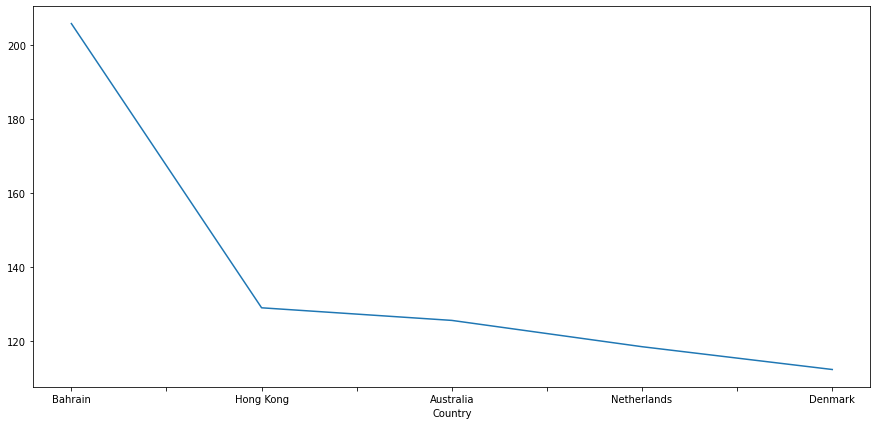

In [86]:
data_f['Spent'].groupby(data_f['Country']).agg('mean').sort_values(ascending = False).head(5).plot(figsize = (15, 7))

Evolution mensuelle du :
-     Montant Médian d’un panier client pour chacun de ces cinq pays

<AxesSubplot:xlabel='Country'>

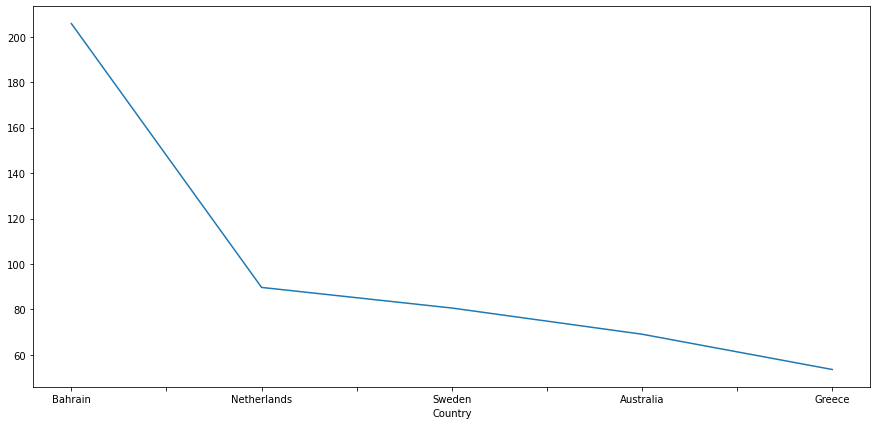

In [87]:
data_f['Spent'].groupby(data_f['Country']).agg('median').sort_values(ascending = False).head(5).plot(figsize = (15, 7))

## Question 6 : Fréquence

-     fréquence des 100 plus gros clients du Royaume.Uni

In [88]:
data_f.head()
data_freq = data_f.copy()

In [89]:
data_freq.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04,1.95,13313.0,United Kingdom,19.5,2011,1,4
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,10.5,2011,1,4
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,10.5,2011,1,4
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04,2.10,13313.0,United Kingdom,10.5,2011,1,4
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04,1.25,13313.0,United Kingdom,12.5,2011,1,4


In [90]:
data_reference = data_freq.InvoiceDate.max()
data_reference = data_reference + datetime.timedelta(days = 1)
data_reference

Timestamp('2011-04-01 00:00:00')

In [91]:
data_freq['days_since_last_spend'] = data_reference - data_freq.InvoiceDate

In [ ]:
data_freq.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day,days_since_last_spend
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04,1.95,13313.0,United Kingdom,19.5,2011,1,4,87 days
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,10.5,2011,1,4,87 days
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,10.5,2011,1,4,87 days
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04,2.10,13313.0,United Kingdom,10.5,2011,1,4,87 days
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04,1.25,13313.0,United Kingdom,12.5,2011,1,4,87 days


In [ ]:
customer_history = data_freq.groupby("CustomerID").min().reset_index()[['CustomerID', 'num_days_since_last_spend']]
customer_history.rename(columns={'num_days_since_last_spend':'Recent_Spend'}, inplace=True)
customer_history.Recent_Spend.describe()

ValueError: Wrong number of items passed 2, placement implies 4

In [ ]:
customer_history.head()

In [ ]:
value = data_freq[['CustomerID', 'Spent']].groupby("CustomerID").sum().reset_index()
customer_history = customer_history.merge(value, how='outer')
customer_history.Spent = customer_history.Spent+0.001
customer_frequency = data_freq[['CustomerID', 'Spent']].groupby("CustomerID").count().reset_index()
customer_frequency.rename(columns={'Spent':'frequency'},inplace=True)
customer_frequency = customer_history.merge(customer_frequency, how='outer')

In [ ]:
customer_history.head()

Fréquence. A quelle fréquence dépensent les 100 plus gros clients du Royaume-Uni ?

In [ ]:
customer_history['Pays'] = data_freq.Country

In [ ]:
customer_history.head()

In [ ]:
united_kingdom = customer_history[customer_history['Pays'] == 'United Kingdom'].sort_values(by=['Spent'], ascending=False)
united_kingdom

In [ ]:
frequence_spent = united_kingdom.frequency.mean()
frequence_spent

In [ ]:
display("Les 100 plus gros clients du Royaume-Uni dépensent a une fréquence de {} % ".format(frequence_spent))

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## II. Modèles

-     1.Question

-     A.Quel sera le chiffre d’affaire global de la société en Décembre 2011 ?

In [92]:
data_f.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04,1.95,13313.0,United Kingdom,19.5,2011,1,4
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,10.5,2011,1,4
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,10.5,2011,1,4
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04,2.10,13313.0,United Kingdom,10.5,2011,1,4
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04,1.25,13313.0,United Kingdom,12.5,2011,1,4


In [95]:
data_ca = data_f[ (data_f['Year']==2011) & (data_f['Month']==12)]

In [96]:
data_ca

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day


In [93]:
Msk = (data_f['Year']==2011) & (data_f['Month'] ==12)
Msk = data_f[Msk]

In [97]:
Msk

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day


In [98]:
Mask2 = (Msk[Msk['Month'] == 12 ])

In [99]:
Mask2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day


In [ ]:
Mask2.groupby(['Country']).agg({'Spent':'median'}).reset_index()

,Country,Spent


In [100]:
united_kingdom_2 = Mask2[Mask2['Country'] == 'United Kingdom']
united_kingdom_2.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day


In [101]:
Chiffre_Affaire = united_kingdom_2.Spent.sum()

In [102]:
Chiffre_Affaire

0.0

In [ ]:
print("le chiffre d’affaire global de la société en Décembre 2011 est de {} euro".format(Chiffre_Affaire))

-     2. Modèle

In [134]:
import pandas as pd

In [103]:
model_donnée = data_f.copy()

In [104]:
model_donnée.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent,Year,Month,Day
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04,1.95,13313.0,United Kingdom,19.5,2011,1,4
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,10.5,2011,1,4
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04,0.42,13313.0,United Kingdom,10.5,2011,1,4
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04,2.10,13313.0,United Kingdom,10.5,2011,1,4
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04,1.25,13313.0,United Kingdom,12.5,2011,1,4


In [163]:
data_spent = model_donnée.groupby(['Year', 'Month', 'Day']).agg({'Spent':'sum'}).reset_index()

In [164]:
data_spent

,Year,Month,Day,Spent
0,2011,1,4,17101.68
1,2011,1,5,66835.17
2,2011,1,6,43372.96
3,2011,1,7,30440.04
4,2011,1,9,15845.60
...,...,...,...,...
70,2011,3,27,9502.72
71,2011,3,28,27146.41
72,2011,3,29,70892.37
73,2011,3,30,32281.31


In [170]:
x = data_spent[['Year', 'Month', 'Day']]
y = data_spent['Spent']

In [171]:
x.head()

,Year,Month,Day
0,2011,1,4
1,2011,1,5
2,2011,1,6
3,2011,1,7
4,2011,1,9


In [184]:
y.head()

0    17101.68
1    66835.17
2    43372.96
3    30440.04
4    15845.60
Name: Spent, dtype: float64

In [185]:
rf = model.fit(x, y)

In [186]:
rf

KMeans(n_clusters=5, random_state=28)

In [187]:
day_list =[ i for i in range(10,32)]

In [188]:
day_list.append(3)

In [189]:
december_day = pd.DataFrame.from_dict({'Year': [2011 for i in range(len(day_list))], 'Month': [12 for i in range(len(day_list))], 'Day' : day_list })

In [190]:
december_day

,Year,Month,Day
0,2011,12,10
1,2011,12,11
2,2011,12,12
3,2011,12,13
4,2011,12,14
5,2011,12,15
6,2011,12,16
7,2011,12,17
8,2011,12,18
9,2011,12,19


In [191]:
data_december = december_day.copy(deep=True)

In [192]:
data_december.head()

,Year,Month,Day
0,2011,12,10
1,2011,12,11
2,2011,12,12
3,2011,12,13
4,2011,12,14


In [181]:
data_december.tail()

,Year,Month,Day
18,2011,12,28
19,2011,12,29
20,2011,12,30
21,2011,12,31
22,2011,12,3


-     Prediction des jours manquants

In [193]:
data_december['amount'] = rf.predict(december_day)

In [194]:
data_december.head()

,Year,Month,Day,amount
0,2011,12,10,1
1,2011,12,11,1
2,2011,12,12,1
3,2011,12,13,2
4,2011,12,14,2


In [197]:
model_donnée_december = data_spent[(data_spent['Year'==2011]) & (data_spent['Month'==12])][['Year', 'Month', 'Day', 'amount']]

KeyError: False

In [198]:
data_december = pd.concat([model_donnée_december, data_december], ignore_index=True)

NameError: name 'model_donnée_december' is not defined

In [ ]:
data_december.sort_values('Day')